In [5]:
## Loading the Libraries
import re
import spacy
import seaborn as sns
import en_core_web_lg # python -m spacy download en_core_web_lg
import pandas as pd
import numpy as np
import nltk
import plotly.express as px
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
# from keras.preprocessing.text import Tokenizer
# from tensorflow.keras.utils import pad_sequences
# from keras.models import Sequential
# from keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding
nltk.download('vader_lexicon')
import panel as pn
import warnings; warnings.filterwarnings('ignore')

def show_panel(df,top=20):
    return pn.widgets.Tabulator(df.head(top),
                    show_index=False,
                    pagination='local', 
                         page_size=10)
        
pn.extension('tabulator')
pn.widgets.Tabulator.theme = 'bootstrap'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rashi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [36]:
## Loading the data
data = pd.read_excel('data.xlsx')
print('The dimension of the dataset is:',data.shape)

The dimension of the dataset is: (24780, 4)


# Exploratory Data Analsyis

In [39]:
data.head(3)

,Keyword,Title,Description,Date
0,Job Market,Trudeau responds to Ford urging feds to cut Me...,Prime Minister Justin Trudeau says the federal...,2024-11-12
1,Job Market,Services around Winnipeg will commemorate Reme...,Each year in November millions of Canadians pa...,2024-11-09
2,Job Market,Man accused of property encroachment violation...,Former Dawson City Mayor Bill Kendrick has fil...,2024-11-08


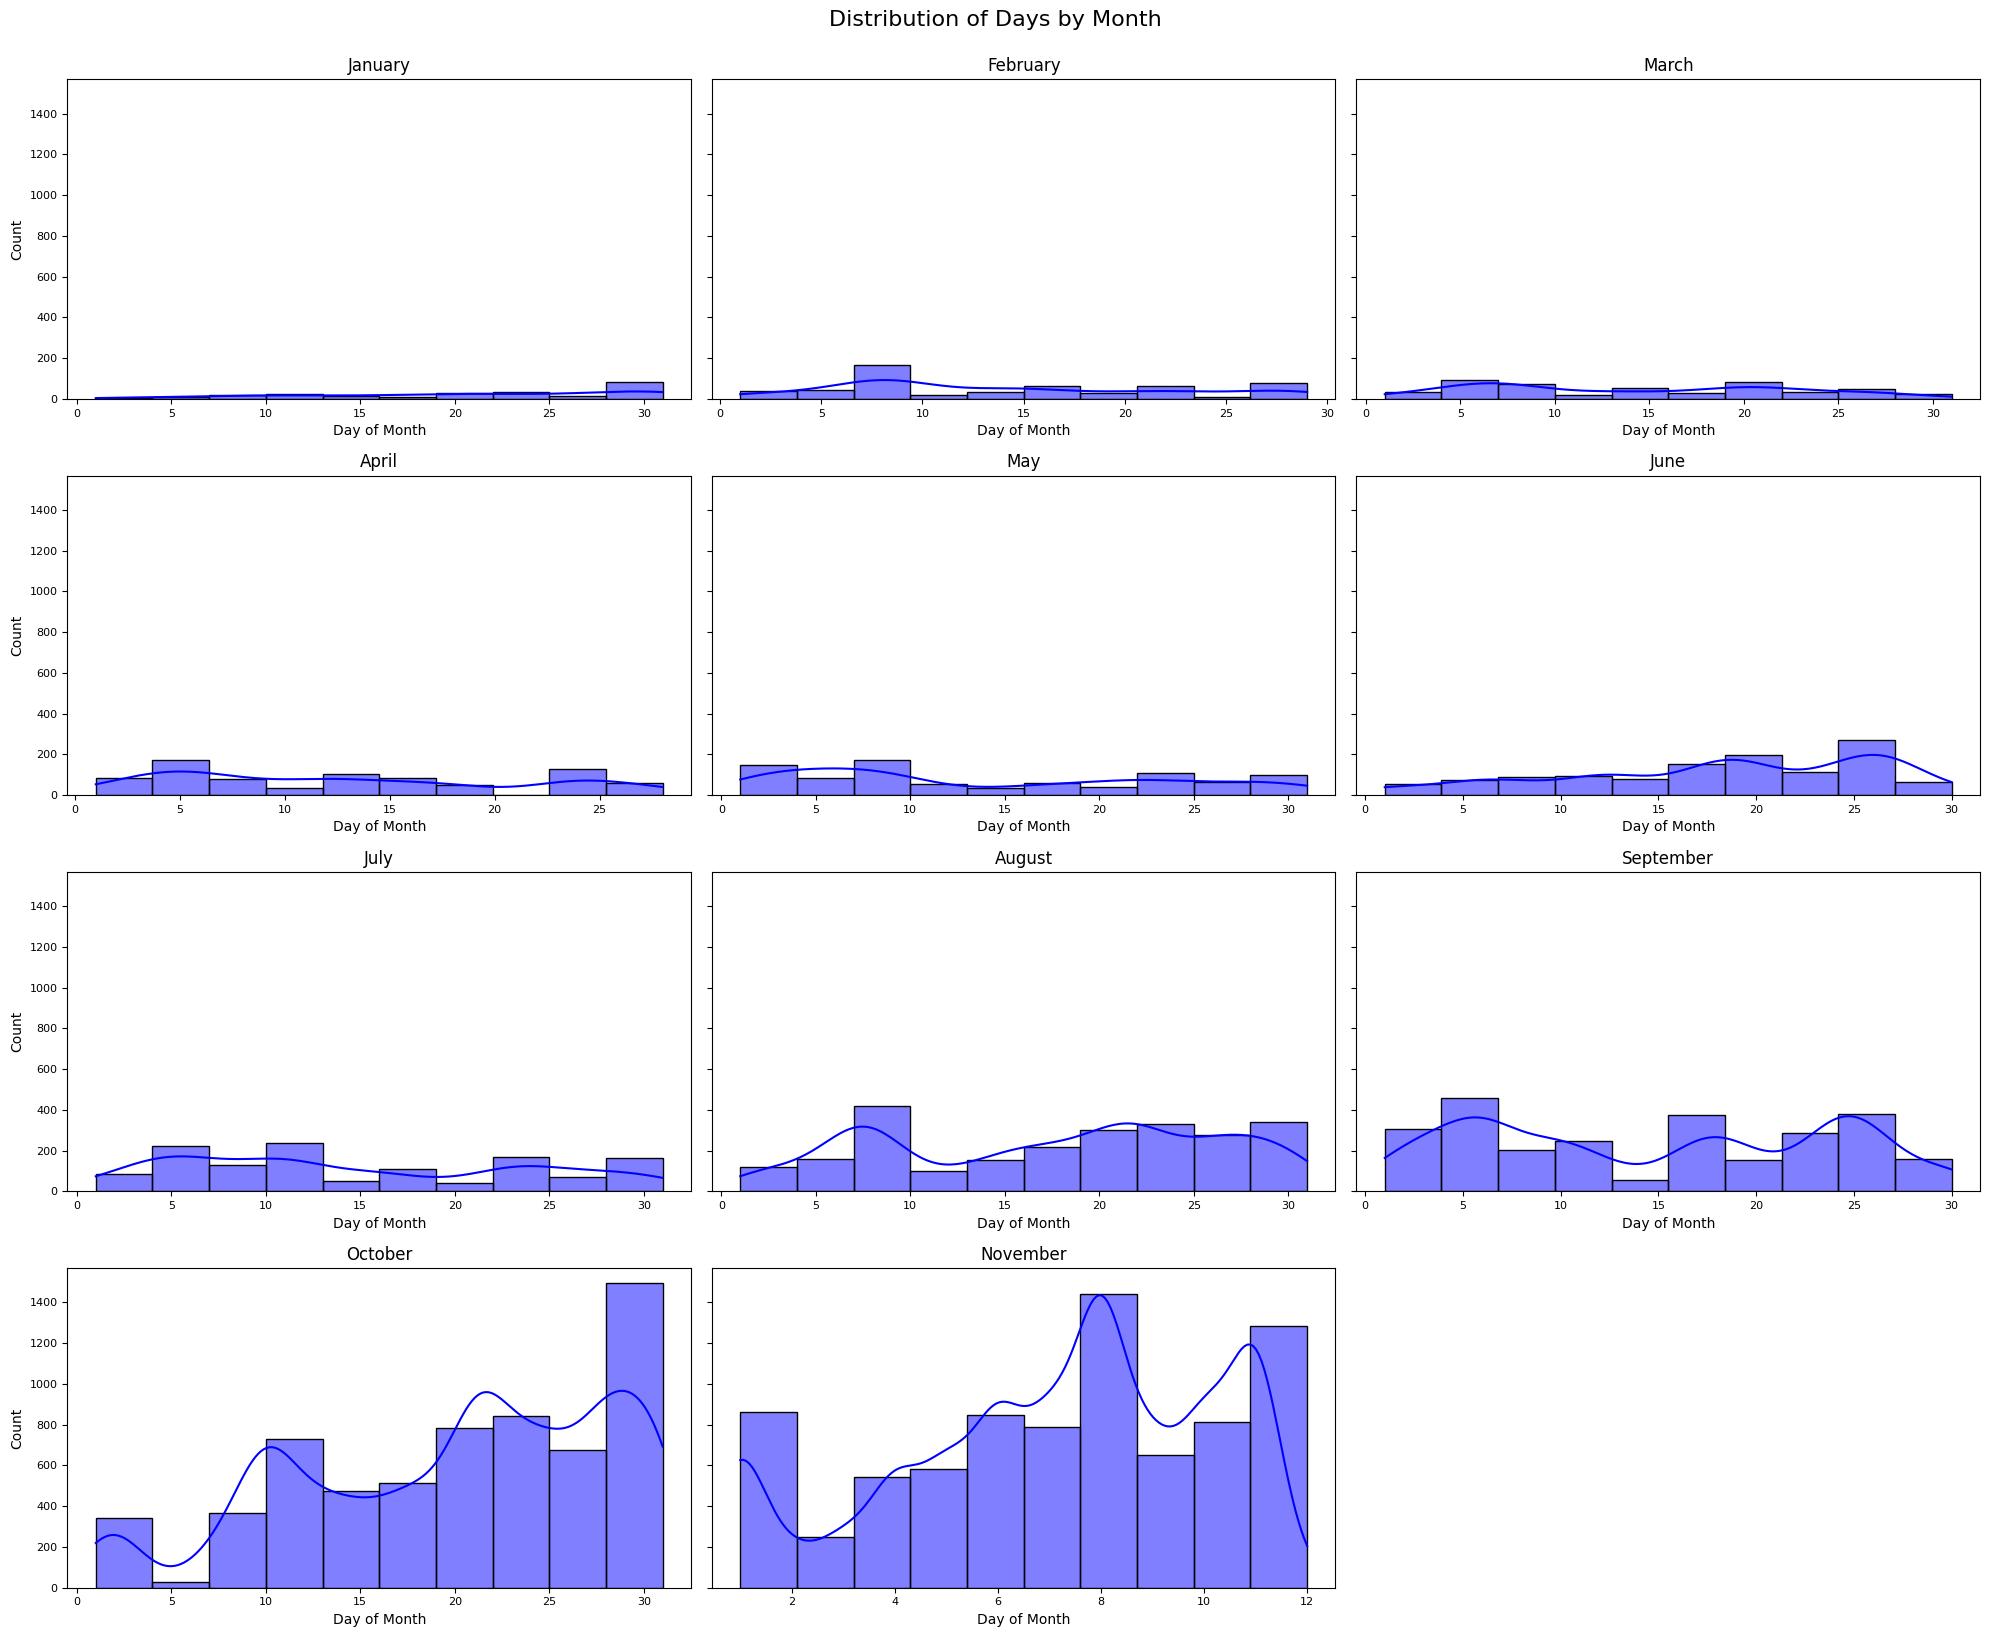

In [60]:
df = data.copy()

# Convert Date column to datetime format and extract Month and Day
df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime
df['Month'] = df['Date'].dt.month_name()  # Extract month name
df['Day'] = df['Date'].dt.day  # Extract day of the month

# Get unique months and sort them in calendar order
unique_months = df['Month'].unique()
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]
unique_months = sorted(df['Month'].unique(), key=lambda x: month_order.index(x))

# Create side-by-side subplots for each month
n_cols = 3  # Number of columns
n_rows = -(-len(unique_months) // n_cols)  # Calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4), sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

for i, month in enumerate(unique_months):
    month_data = df[df['Month'] == month]
    sns.histplot(month_data['Day'], bins=10, kde=True, ax=axes[i], color="blue", edgecolor="black")
    axes[i].set_title(f'{month}', fontsize=12)
    axes[i].set_xlabel('Day of Month', fontsize=10)
    axes[i].set_ylabel('Count', fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=8)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better visuals
plt.tight_layout()
plt.suptitle("Distribution of Days by Month", fontsize=16, y=1.02)  # Add a global title
plt.show()



In [63]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Bar plot for counts by month
bar_fig = px.bar(
    df['Month'].value_counts().sort_index(),
    title='Number of Articles by Month in 2024',
    labels={'index': 'Month', 'value': 'Count'},
    color_discrete_sequence=['#636EFA']
)
bar_fig.update_layout(xaxis_title='Month', yaxis_title='Count')


# Bar plot for counts by unique values in the 'Keyword' column
keyword_fig = px.bar(
    df['Keyword'].value_counts(),
    title='Frequency of Keywords',
    labels={'index': 'Keyword', 'value': 'Count'},
    color_discrete_sequence=['#FFA07A'],
    template="plotly_white"
)

# Create subplots to display both plots side by side
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Number of Articles by Month in 2024", "Frequency of Keywords"],
    column_widths=[0.5, 0.5]
)

# Add bar plot for articles by month
for trace in bar_fig.data:
    fig.add_trace(trace, row=1, col=1)

# Add bar plot for frequency of keywords
for trace in keyword_fig.data:
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(
    height=600, width=1200, showlegend=False, title_text="Article and Keyword Distribution"
)

# Show the plot
fig.show()

In [8]:
for i in range(0,3):
    print("Title:", data.loc[i, 'Title'])
    print("Description:", data.loc[i, 'Description'])

Title: Trudeau responds to Ford urging feds to cut Mexico from North American trade agreement
Description: Prime Minister Justin Trudeau says the federal government is going to continue to work with the U.S. and ‘hopefully Mexico’ to ensure they are united in their ‘desire to protect good jobs.’ Ontario Premier Doug Ford said in a statement Tuesday that Mexico has become a ‘backdoor for Chinese cars, auto parts and other products into Canadian and American markets.’
Title: Services around Winnipeg will commemorate Remembrance Day | CBC News
Description: Each year in November millions of Canadians pay tribute and collectively remember military servicemen who died for their country, and a number of services and ceremonies will be held around Winnipeg on Monday.
Title: Man accused of property encroachment violations in Dawson City files his defence against town | CBC News
Description: Former Dawson City Mayor Bill Kendrick has filed his defence against the town's encroachment violation la

In [9]:
data.isnull().sum()

Keyword        0
Title          0
Description    0
Date           0
dtype: int64

In [10]:
duplicates = data[data.duplicated()]
print('The number of duplicate rows are:',len(duplicates))

The number of duplicate rows are: 23413


In [62]:
# # # Count articles by each keyword
# # keyword_counts = data['Keyword'].value_counts()
# # plt.figure(figsize=(12, 5))
# # sns.barplot(x=keyword_counts.index, y=keyword_counts.values, palette='viridis')

# # # Add titles and labels
# # plt.title('Distribution of Articles by Keyword', fontsize=16, fontweight='bold')
# # plt.xlabel('Keywords', fontsize=14)
# # plt.ylabel('Number of Articles', fontsize=14)
# # plt.xticks(rotation=45, fontsize=12)
# # plt.tight_layout()

# # plt.show()

# px.bar(data['Keyword'].value_counts(),template="plotly_white")

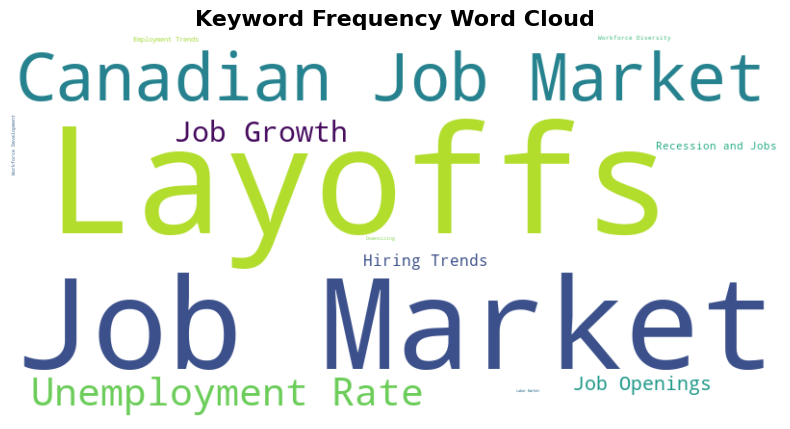

In [12]:
from wordcloud import WordCloud
keyword_counts = data['Keyword'].value_counts()
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(keyword_counts)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keyword Frequency Word Cloud', fontsize=16, fontweight='bold')
plt.show()


# Data Preparation

The   
- The duplicated rows to be dropped from the dataset
- The '|CIBC News' part to removed from the titles
- Merging the 'Title' and 'Description' coloumns and creating a new column named 'Artiles'

In [13]:
data = data.drop_duplicates()
data.shape

(1367, 4)

In [14]:
data['Title'] = data['Title'].str.replace(r'\s\|\s.*$', '', regex=True)

In [15]:
# Combine Title and Description
data['Article'] = data['Title'] + " " + data['Description']
data.head()

,Keyword,Title,Description,Date,Article
0,Job Market,Trudeau responds to Ford urging feds to cut Me...,Prime Minister Justin Trudeau says the federal...,November 12,Trudeau responds to Ford urging feds to cut Me...
1,Job Market,Services around Winnipeg will commemorate Reme...,Each year in November millions of Canadians pa...,November 9,Services around Winnipeg will commemorate Reme...
2,Job Market,Man accused of property encroachment violation...,Former Dawson City Mayor Bill Kendrick has fil...,November 8,Man accused of property encroachment violation...
3,Job Market,Manitoba veteran goes overseas to make offerin...,Aside from an oval photo framed in bubble glas...,November 8,Manitoba veteran goes overseas to make offerin...
4,Job Market,Moncton murder trial jury to continue delibera...,The jury in a Moncton murder trial will contin...,November 8,Moncton murder trial jury to continue delibera...


In [16]:
data = data.drop(['Title','Description'], axis=1)

In [ ]:
## Need to verify the steps for preprocessing
# ## For initial modelling keeping the articles as it is

def preprocess_text_custom(text):
    text = text.lower()
    # Keep $, %, retain common financial terms
    # text = re.sub(r'[^a-zA-Z0-9\s!?.,$%#@]', '', text)
    # Replace common abbreviations or financial terms if needed
    # text = re.sub(r'\$', ' dollar ', text)  # Replace $ with 'dollar'
    # text = re.sub(r'billion', 'b', text)  # Normalize large numbers
    # text = re.sub(r'\s+', ' ', text).strip()
    return text

data['Article'] = data['Article'].apply(preprocess_text_custom)


In [15]:
data.to_clipboard()

# Sentiment Evaluation

In [16]:
data['sent_blob'] = data['Article'].apply(lambda row: TextBlob(row).sentiment.polarity)
data.head()

,Keyword,Date,Article,sent_blob
0,Job Market,November 12,Trudeau responds to Ford urging feds to cut Me...,0.115000
1,Job Market,November 9,Services around Winnipeg will commemorate Reme...,-0.100000
2,Job Market,November 8,Man accused of property encroachment violation...,0.000000
3,Job Market,November 8,Manitoba veteran goes overseas to make offerin...,0.094643
4,Job Market,November 8,Moncton murder trial jury to continue delibera...,-0.050000


In [17]:
data.drop(['sent_blob'],axis=1,inplace=True)

# Sentiment Labelling

In [18]:
class make_labels:
    
    def __init__(self, df, text_column):
        self.df = df
        self.text_column = text_column

    def sentiment_val(self):
        # Add polarity score
        self.df['blob_sent'] = self.df[self.text_column].apply(lambda row: TextBlob(row).sentiment.polarity)
        # Add sentiment category
        self.df['Sentiment'] = self.df['blob_sent'].apply(
            lambda x: 'Positive' if x > 0.1 else 'Negative' if x < -0.1 else 'Neutral'
        )
        return self.df

# Example usage:
labels = make_labels(data, 'Article')
data = labels.sentiment_val()
data.head()

,Keyword,Date,Article,blob_sent,Sentiment
0,Job Market,November 12,Trudeau responds to Ford urging feds to cut Me...,0.115000,Positive
1,Job Market,November 9,Services around Winnipeg will commemorate Reme...,-0.100000,Neutral
2,Job Market,November 8,Man accused of property encroachment violation...,0.000000,Neutral
3,Job Market,November 8,Manitoba veteran goes overseas to make offerin...,0.094643,Neutral
4,Job Market,November 8,Moncton murder trial jury to continue delibera...,-0.050000,Neutral


In [19]:
sentiment_counts = data['Sentiment'].value_counts().reset_index()

fig = px.bar(sentiment_counts, x='Sentiment', y='count', title='Sentiment Distribution by Textblob', color='Sentiment', 
             template="plotly_white") 
fig.show()

In [20]:
label_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
data['label'] = data['Sentiment'].map(label_mapping)


In [21]:
data.head()

,Keyword,Date,Article,blob_sent,Sentiment,label
0,Job Market,November 12,Trudeau responds to Ford urging feds to cut Me...,0.115000,Positive,2
1,Job Market,November 9,Services around Winnipeg will commemorate Reme...,-0.100000,Neutral,1
2,Job Market,November 8,Man accused of property encroachment violation...,0.000000,Neutral,1
3,Job Market,November 8,Manitoba veteran goes overseas to make offerin...,0.094643,Neutral,1
4,Job Market,November 8,Moncton murder trial jury to continue delibera...,-0.050000,Neutral,1


In [22]:
import warnings; warnings.filterwarnings('ignore')
from copy import deepcopy
import seaborn as sns; sns.set(style='whitegrid',
                              font_scale=0.7)


class nlp_evals:
    
    def __init__(self,df,corpus,label,
                 spacy_model='en_core_web_sm',
                 title='accuracy evaluation'
                ):
        
        self.df = deepcopy(df)
        self.corpus = corpus
        self.label = label
        self.spacy_model = spacy_model
        self.embeddings = self.get_embeddings()
        self.seed = 32
        self.num_folds = 4
        self.title = title

    def get_embeddings(self):
        
        # NLP pipline
        nlp = spacy.load(self.spacy_model)
        if(self.spacy_model is 'en_core_web_sm'):
            embedding_dims = 96
        elif(self.spacy_model is 'en_core_web_lg'):
            embedding_dims = 300
        
        # average embedding vector for each document
        all_vectors = np.array([np.array([token.vector for token in nlp(s) ]).mean(axis=0)*np.ones((embedding_dims)) \
                                   for s in self.df[self.corpus]])
        print(all_vectors.shape)
        print('embeddings loaded!')
        return all_vectors
        
    def tts(self,ratio=0.1):
        
        # split out validation dataset for the end
        Y = self.df[self.label]
        X = self.embeddings

        X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                            test_size=ratio, 
                                                            random_state=32)
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train 
        self.y_test = y_test
        print('train/test split!')
        
    def define_models(self,models):
        self.models = models
        print('models set!')
        
    def kfold(self):
        
        self.results = []
        self.names = []
        self.test_results = []
        self.train_results = []
        self.cv_results = []
        
        lX_train = deepcopy(self.X_train)
        lX_test = deepcopy(self.X_test)
        ly_train = deepcopy(self.y_train.to_frame())
        ly_test = deepcopy(self.y_test.to_frame())
        
        print('model, cv mean, cv std, train, test')

        for name, model in self.models:
            
            # cross validation on training dataset
            kfold = KFold(n_splits=self.num_folds, shuffle=True,random_state=self.seed)
            cv_results = cross_val_score(model, 
                                         self.X_train, self.y_train,
                                         cv=kfold,
                                         scoring='accuracy')
            self.results.append(cv_results)
            self.names.append(name)
            self.cv_results.append(cv_results.mean())

           # Full Training period
            res = model.fit(self.X_train, self.y_train)
            ytrain_res = res.predict(self.X_train)
            acc_train = accuracy_score(ytrain_res,self.y_train)
            self.train_results.append(acc_train)

            # Test results
            ytest_res = res.predict(self.X_test)
            acc_test = accuracy_score(ytest_res, self.y_test)
            self.test_results.append(acc_test)    

            msg = "%s: %f (%f) %f %f" % (name, 
                                         cv_results.mean(), 
                                         cv_results.std(), 
                                         acc_train, 
                                         acc_test)
            
            ly_train[f'{name}_train'] = ytrain_res
            ly_test[f'{name}_test'] = ytest_res
            
            print(msg)
            print(confusion_matrix(ytest_res, self.y_test))
            
        
        self.ly_train = ly_train
        self.ly_test = ly_test
            
        print('evaluation finished!')
        
    def plot_results(self):

        ldf_res = pd.DataFrame({'cv':self.cv_results,
                                'train':self.train_results,
                                'test':self.test_results})
        
        plot_df = ldf_res.melt()
        local_names = deepcopy(self.names)
        local_names = local_names * 3
      
        plot_df['names'] = local_names
        
        ptable = pd.pivot_table(plot_df,
                                values='value',
                                index='variable',
                                columns='names')

        fig,ax = plt.subplots(figsize=(5,1.5))
        sns.heatmap(ptable,annot=True,
                    fmt=".2f",
                    ax=ax,
                    cmap='crest')
        plt.title(self.title)

In [23]:
evals_nlp = nlp_evals(df=data,            # define the corpus dataframe
                      corpus='Article', # define which column contains the corpus
                      label='label',  # define the column which contains the label
                      title='self defined labels') 


(1367, 96)
embeddings loaded!


In [24]:
evals_nlp.tts()


train/test split!


In [25]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

evals_nlp.define_models(models)

models set!


In [26]:
evals_nlp.kfold()

model, cv mean, cv std, train, test
LR: 0.543120 (0.035296) 0.607317 0.532847
[[ 0  0  0]
 [15 56 32]
 [ 1 16 17]]
KNN: 0.517899 (0.011697) 0.698374 0.576642
[[ 7  8  3]
 [ 7 53 27]
 [ 2 11 19]]
CART: 0.645530 (0.016068) 1.000000 0.591241
[[ 7  8  6]
 [ 6 51 20]
 [ 3 13 23]]
SVM: 0.556131 (0.027598) 0.669106 0.562044
[[ 0  0  0]
 [15 65 37]
 [ 1  7 12]]
RF: 0.672382 (0.020365) 1.000000 0.715328
[[ 6  0  0]
 [ 8 69 26]
 [ 2  3 23]]
evaluation finished!


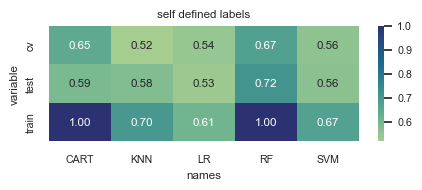

In [27]:
evals_nlp.plot_results()

In [28]:
### Larger embeddings
evals_nlp = nlp_evals(df=data,   # define the corpus dataframe
                      corpus='Article', # define which column contains the corpus
                      label='label',  # define the column which contains the label
                      spacy_model = 'en_core_web_lg') 


evals_nlp.tts()

# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

evals_nlp.define_models(models)
evals_nlp.kfold()

(1367, 300)
embeddings loaded!
train/test split!
models set!
model, cv mean, cv std, train, test
LR: 0.608155 (0.018488) 0.699187 0.605839
[[ 1  1  0]
 [14 57 24]
 [ 1 14 25]]
KNN: 0.534966 (0.021536) 0.715447 0.562044
[[ 6  2  2]
 [ 7 49 25]
 [ 3 21 22]]
CART: 0.613018 (0.015668) 1.000000 0.613139
[[ 8  6  4]
 [ 5 51 20]
 [ 3 15 25]]
SVM: 0.530900 (0.004187) 0.552846 0.532847
[[ 0  0  0]
 [16 72 48]
 [ 0  0  1]]
RF: 0.681316 (0.021117) 1.000000 0.729927
[[ 7  0  0]
 [ 8 68 24]
 [ 1  4 25]]
evaluation finished!


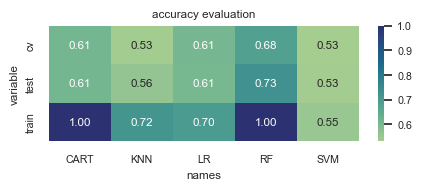

In [29]:
evals_nlp.plot_results()

In [ ]:
## Try with data preprocessing


In [1]:
### Vader Sentiments

# Conclusion